In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os, shutil
from tqdm import tqdm
import pickle

from keras.applications.resnet50 import ResNet50
# from keras_applications.resnet import ResNet152
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten,Input
from keras.models import Model, Sequential, load_model
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend, layers, models,utils

import numpy as np
import pandas as pd
import tensorflow as tf

# 预处理

In [2]:
data_dir = './{}/'
nb_class = len(os.listdir(data_dir.format('train')))
data = {}
for i in ['train', 'valid']:
    data[i] = {x: os.listdir(data_dir.format(i)+x) for x in os.listdir(data_dir.format(i))}
nb_train_samples = sum([len(data['train'][x]) for x in data['train'].keys()])
nb_valid_samples = sum([len(data['valid'][x]) for x in data['train'].keys()])

In [3]:
"./train/cat.0.jpg"

'./train/cat.0.jpg'

In [4]:
print(any([data['valid']['cat'][x] in data['train']['cat'] for x in range(len(data['valid']['cat']))]))
print(any([data['valid']['dog'][x] in data['train']['dog'] for x in range(len(data['valid']['dog']))]))

False
False


## 图像变换

暂时参考以下博文为蓝本：https://zhuanlan.zhihu.com/p/26693647

In [11]:
datagen = {'train': image.ImageDataGenerator(
   preprocessing_function=preprocess_input,
#     rotation_range=30,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True
),
           'valid':image.ImageDataGenerator(
   preprocessing_function=preprocess_input
)
          }

用了`preprocess_input()`就不需要`rescale`参数了。

https://stackoverflow.com/questions/47555829/preprocess-input-method-in-keras

In [8]:
im_width, im_height = 224, 224
batch_size = 64

generator = {x: datagen[x].flow_from_directory(
    data_dir.format(x),
    target_size=(im_width, im_height),
    batch_size=batch_size,
    seed = 123,
    class_mode = 'binary',
    shuffle=True  
    
) for x in datagen.keys()}

Found 16663 images belonging to 2 classes.
Found 8208 images belonging to 2 classes.


## 载入模型

载入模型并排除顶部的全连接层。

In [12]:
# tf.reset_default_graph() 
model_base = ResNet50(weights='imagenet', include_top=False, input_shape = (im_width, im_height, 3))
# model_base = ResNet152(include_top = False, weights = 'imagenet', backend = backend, layers = layers, models = models, utils = utils,
#                        input_shape = (im_width, im_height, 3))

In [13]:
x = model_base.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3,)(x)
x = Dense(500, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=model_base.input, outputs=output)

In [20]:
name.name

'dense_6'

In [8]:
# model_base.summary()

添加自己的层：

model = Sequential()
model.add(ResNet50(weights='imagenet', include_top=False, input_shape = (im_width, im_height, 3)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [11]:
# model.summary()

查看冻结层前后的可训练层数：

In [14]:
print('Number of trainable weights befor freezing the model_base:', len(model.trainable_weights))
for layer in model.layers[:173]:
    layer.trainable = False
print('Number of trainable weights after freezing the model_base:', len(model.trainable_weights))

Number of trainable weights befor freezing the model_base: 218
Number of trainable weights after freezing the model_base: 6


编译模型：

In [15]:
lr = 0.0005
# from keras.utils import multi_gpu_model
# model = multi_gpu_model(model_base, gpus=8)
model.compile(loss = "binary_crossentropy", optimizer = optimizers.Adam(lr=lr), metrics=["accuracy"])

训练模型：

In [16]:
epochs = 20
history = model.fit_generator(generator['train'],
                              steps_per_epoch=nb_train_samples // 128,
                              epochs=epochs,
                              validation_data=generator['valid'],
                              validation_steps=nb_valid_samples // 128)

Epoch 1/20
130/130 [==============================] - 65s 503ms/step - loss: 0.1315 - acc: 0.9470 - val_loss: 0.2077 - val_acc: 0.9431
Epoch 2/20
130/130 [==============================] - 60s 465ms/step - loss: 0.0848 - acc: 0.9667 - val_loss: 0.0757 - val_acc: 0.9768
Epoch 3/20
130/130 [==============================] - 68s 520ms/step - loss: 0.0706 - acc: 0.9733 - val_loss: 0.1834 - val_acc: 0.9511
Epoch 4/20
130/130 [==============================] - 61s 470ms/step - loss: 0.0773 - acc: 0.9711 - val_loss: 0.0736 - val_acc: 0.9785
Epoch 5/20
130/130 [==============================] - 67s 516ms/step - loss: 0.0583 - acc: 0.9772 - val_loss: 0.2329 - val_acc: 0.9392
Epoch 6/20
130/130 [==============================] - 61s 467ms/step - loss: 0.0544 - acc: 0.9797 - val_loss: 0.1159 - val_acc: 0.9734
Epoch 7/20
130/130 [==============================] - 67s 515ms/step - loss: 0.0467 - acc: 0.9832 - val_loss: 0.0970 - val_acc: 0.9746
Epoch 8/20
130/130 [==============================] - 6

保存模型checkpoint：

In [16]:
model.save_weights('model_binary_wieghts.h5')
model.save('model_binary.h5')

# 重新载入模型

In [17]:
# model = load_model('model_binary.h5')

可视化：

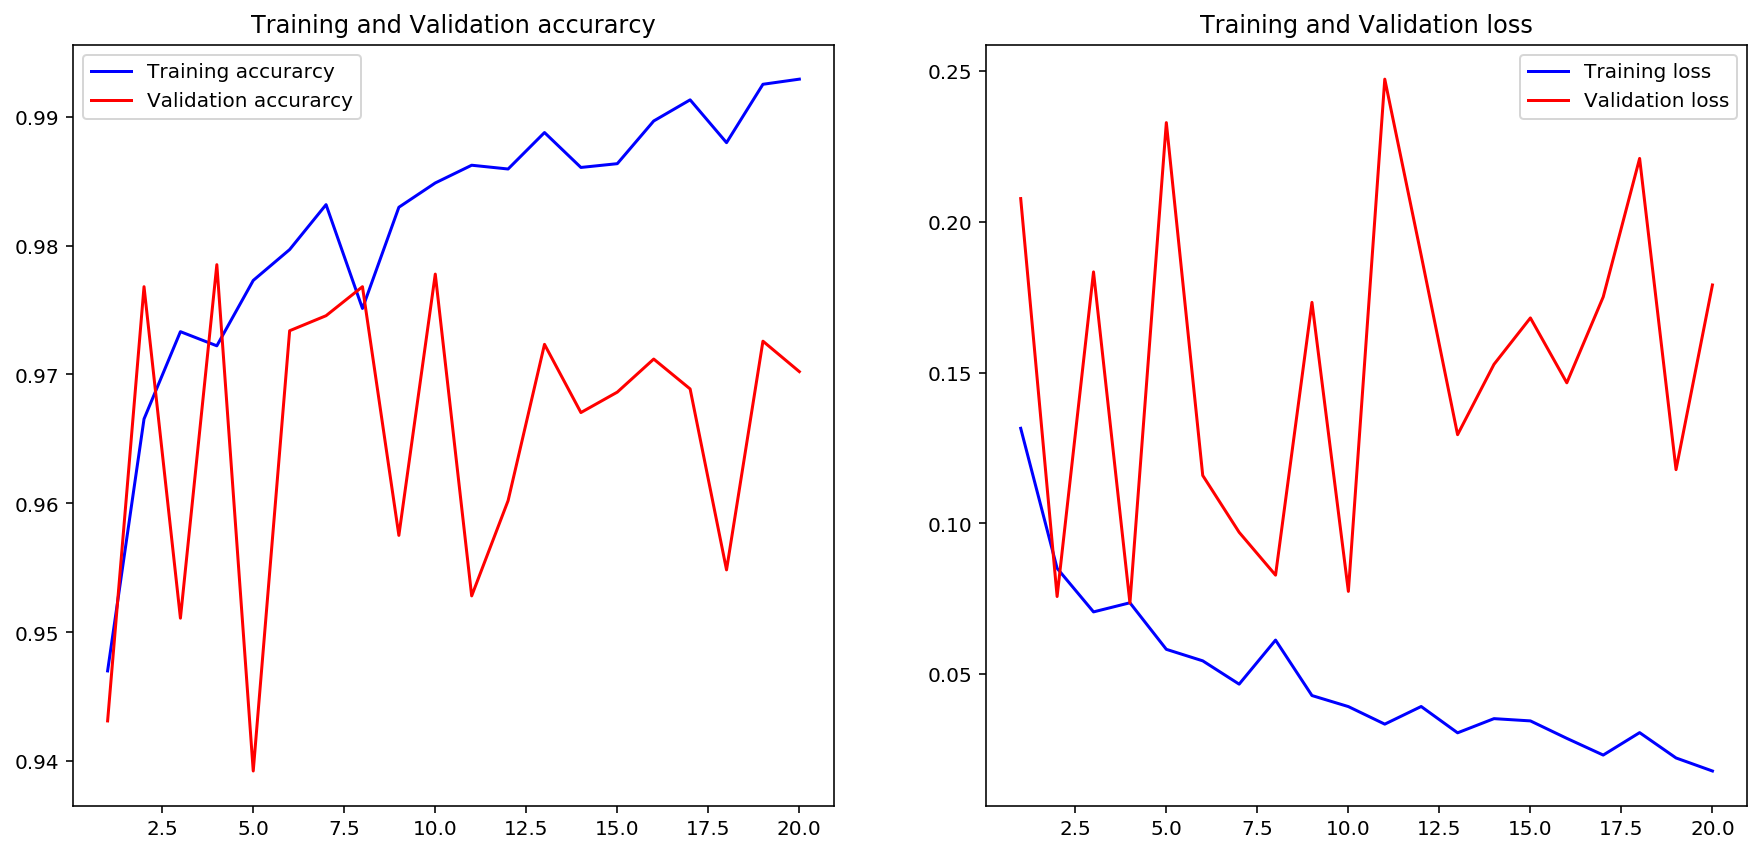

In [17]:
#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.figure(figsize = [15, 7])
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.subplot(1,2,2)
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.savefig('loss and acc.jpg', bbox_inches = 'tight')
plt.show()

# 预测

6.150793e-06


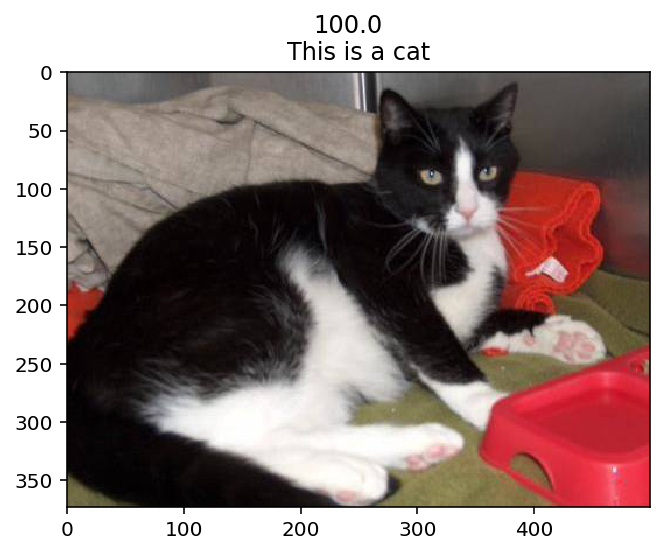

In [ ]:
test_imgs = os.listdir(data_dir.format('test'))
img_path = data_dir.format('test') + test_imgs[3]
# img_path = './test04.jpg'
img = image.load_img(img_path, target_size=(im_width, im_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)[0][0]
print(preds)
img_show = mpimg.imread(img_path)
plt.imshow(img_show)
plt.title('This is a {}'.format('dog' if preds > 0.5 else 'cat'))
plt.suptitle('probability: {} percent'.format(round(preds, 3)*100) if preds > 0.5 else round(1-preds, 3)*100);

全部预测，制作csv表

In [ ]:
test_imgs = os.listdir(data_dir.format('test'))
ids = []
label = []
for i in tqdm(test_imgs):
    img = image.load_img(data_dir.format('test') + i, target_size=(im_width, im_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    label.append(model.predict(x)[0][0])
    ids.append(int(i.split('.')[0]))

 50%|████▉     | 6201/12500 [04:13<03:43, 28.19it/s]

In [ ]:
sub = pd.DataFrame({'id': ids, 'label': label}).sort_values('id',axis = 0, ascending = True)
sub.to_csv('submission.csv', index = False)

# 参考资料

+ https://zhuanlan.zhihu.com/p/26693647
+ https://medium.com/@14prakash/transfer-learning-using-keras-d804b2e04ef8
+ https://www.kaggle.com/risingdeveloper/transfer-learning-in-keras-on-dogs-vs-cats